In [1]:
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import learning_curve,RepeatedKFold

from sklearn.pipeline import make_pipeline
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from scipy import stats
from scipy.special import boxcox1p
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso,LassoCV
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet

from sklearn.feature_selection import SelectFromModel
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer,quantile_transform,PowerTransformer
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler

from sklearn.manifold import TSNE

%matplotlib inline

In [2]:

#dataframe final
df_final = pd.read_csv("../data/DF_train15noChangeContact_skempiAB_modeller_final.csv",index_col=0)


pdb_names = df_final.index
features_names = df_final.drop('ddG_exp',axis=1).columns
df_final.shape

(1392, 78)

In [3]:
# Split train and independent test data

X_train, X_test, y_train, y_test = train_test_split(df_final.drop('ddG_exp',axis=1), df_final['ddG_exp'], 
                                                    test_size=0.2, random_state=13)                                               

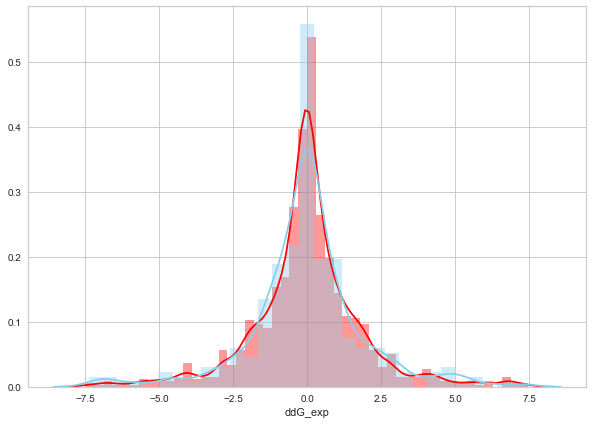

In [4]:
f, ax = plt.subplots(figsize=(10, 7))

sns.distplot(y_train, color="red", label="ddG_exp_train");
sns.distplot(y_test, color="skyblue", label="ddG_exp_test");



 mu = 0.00 and sigma = 1.88



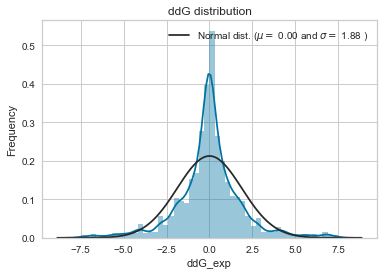

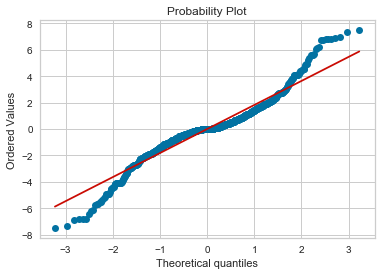

In [5]:
sns.distplot(y_train, fit=stats.norm);

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('ddG distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

# probably need to transform target variable

## Correlation

In [7]:
# join train data for Exploratory analisis of training data
train = X_train.join(y_train)

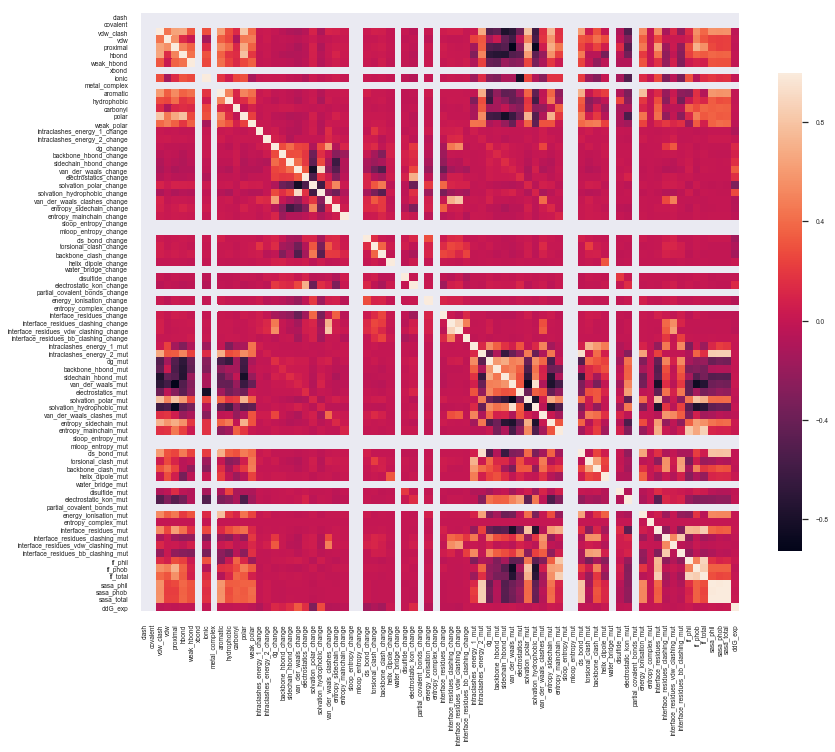

In [8]:
sns.set(font_scale=0.6)

#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(14, 11))
sns.heatmap(corrmat, square=True,cbar_kws={"shrink": .8});

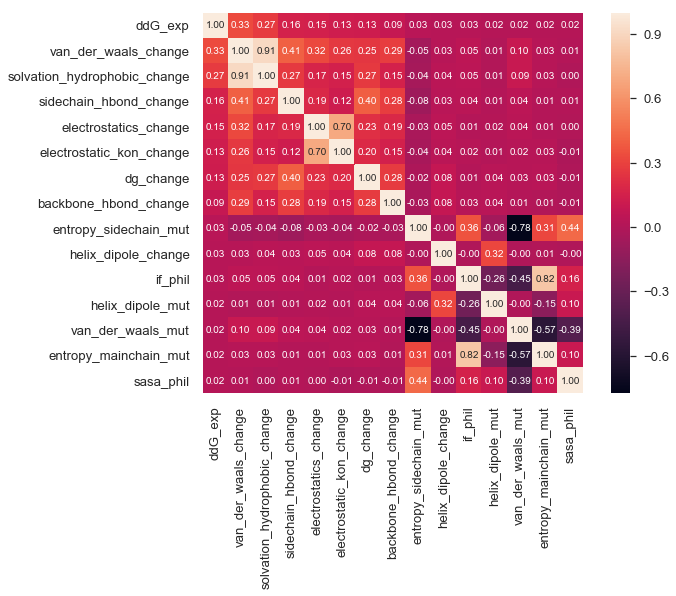

In [9]:
sns.set(font_scale=1.2)


#top 10. correlation matrix
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'ddG_exp')['ddG_exp'].index
cm = np.corrcoef(train[cols].values.T)

f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values);
#plt.show()

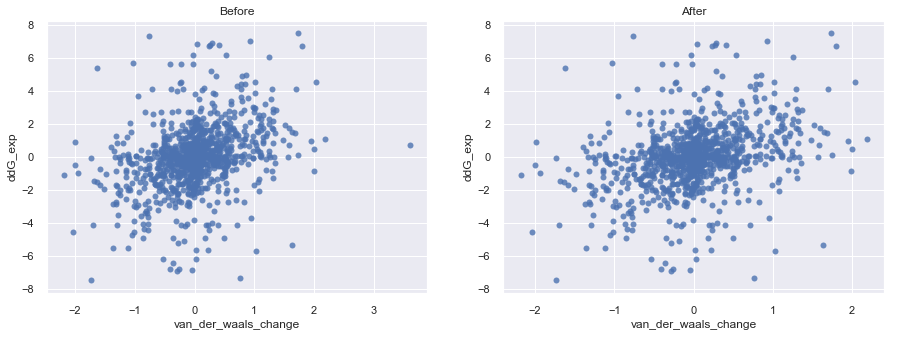

In [10]:
sns.set(font_scale=1)

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['van_der_waals_change'], y=train['ddG_exp'], fit_reg=False).set_title("Before")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['van_der_waals_change']>3)].index)
g = sns.regplot(x=train['van_der_waals_change'], y=train['ddG_exp'], fit_reg=False).set_title("After")

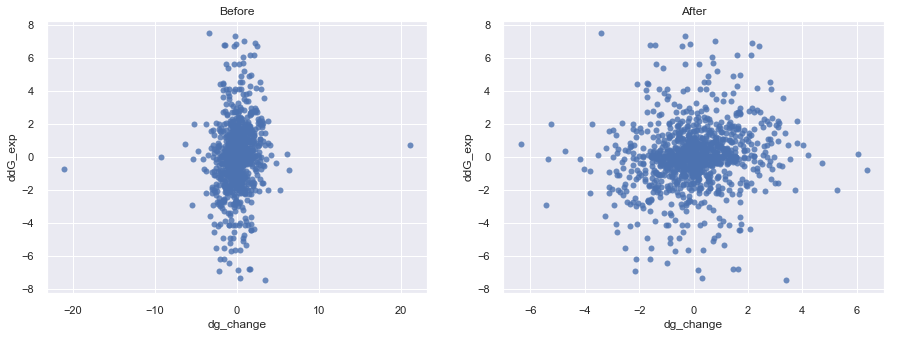

In [11]:
sns.set(font_scale=1)

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['dg_change'], y=train['ddG_exp'], fit_reg=False).set_title("Before")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['dg_change'].abs()>8)].index)
g = sns.regplot(x=train['dg_change'], y=train['ddG_exp'], fit_reg=False).set_title("After")

### NO missing values, skip this dataprocess

## 

### Feature engeenering, checking interaction of sift contact with the highest correlated energetic feature
In order to treat this dataset, first I will check if adding interactions betwen some features improve corr, next i will check for skewess features. Finally i will write a custom transform class for every step.

In [12]:
y_train = train['ddG_exp']
X_train = train.drop('ddG_exp',axis=1)

### Check corr of new features

In [10]:
features_interaction_contactVDW = X_train.iloc[:,:15].mul(X_train["van_der_waals_change"],axis=0)# funciona mucho mejor
features_interaction_contactVDW.columns = features_interaction_contactVDW.columns.str[:]+"_vdw_change_interaction"


In [11]:
corr_matrix = features_interaction_contactVDW.corrwith(y_train,axis=0)#.abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
print(corr_matrix.sort_values(ascending=False).round(6))

hbond_vdw_change_interaction            0.364546
polar_vdw_change_interaction            0.349457
weak_polar_vdw_change_interaction       0.347648
vdw_clash_vdw_change_interaction        0.346148
weak_hbond_vdw_change_interaction       0.341377
proximal_vdw_change_interaction         0.331598
hydrophobic_vdw_change_interaction      0.295767
vdw_vdw_change_interaction              0.295753
ionic_vdw_change_interaction            0.252295
aromatic_vdw_change_interaction         0.239054
carbonyl_vdw_change_interaction         0.209229
clash_vdw_change_interaction                 NaN
covalent_vdw_change_interaction              NaN
xbond_vdw_change_interaction                 NaN
metal_complex_vdw_change_interaction         NaN
dtype: float64


### Check skewness

In [12]:
skew_features = X_train.skew().sort_values(ascending=False)
skew_features

interface_residues_vdw_clashing_mut      6.886928
cis_bond_mut                             2.963595
intraclashes_energy_2_mut                2.953448
interface_residues_bb_clashing_mut       2.902191
interface_residues_clashing_mut          2.566482
sasa_phob                                1.963085
sasa_total                               1.942088
energy_ionisation_mut                    1.862720
sasa_phil                                1.838843
van_der_waals_clashes_change             1.638112
torsional_clash_mut                      1.624876
aromatic                                 1.595366
if_phil                                  1.488984
carbonyl                                 1.362180
entropy_mainchain_mut                    1.285913
vdw_clash                                1.281802
van_der_waals_clashes_mut                1.218391
if_total                                 1.164993
intraclashes_energy_1_mut                1.084688
energy_ionisation_change                 0.826565


### Check features by percetange of zero values

In [13]:
overfit = []
for i in X_train.columns:
    counts = X_train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X_train) * 100 >90.:
        overfit.append(i)
overfit

['clash',
 'covalent',
 'xbond',
 'metal_complex',
 'sloop_entropy_change',
 'mloop_entropy_change',
 'cis_bond_change',
 'water_bridge_change',
 'partial_covalent_bonds_change',
 'entropy_complex_change',
 'interface_residues_clashing_change',
 'interface_residues_vdw_clashing_change',
 'interface_residues_bb_clashing_change',
 'sloop_entropy_mut',
 'mloop_entropy_mut',
 'water_bridge_mut',
 'partial_covalent_bonds_mut',
 'entropy_complex_mut',
 'interface_residues_vdw_clashing_mut']

### make custom transformers for preprocess in pipeline

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeaturesInteractions(BaseEstimator, TransformerMixin):
    
    #Class constructor method that takes ..
    def __init__(self, interaction1, interaction2 ):
        self.interaction1 = interaction1
        self.interaction2 = interaction2
        
    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        
        return self
    
    def transform(self, X , y=None ):
        
        X_interactions = X.loc[:,self.interaction1].mul(X[self.interaction2],axis=0)
        X_interactions.columns = X_interactions.columns.values+'/{}'.format(self.interaction2)
        # set columns names
        
        X = X.join(X_interactions)
        
        return X
    
class SkewTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=0.6, method='quantile'):
        self.threshold = threshold
        self.method = method
        
    #Return self nothing else to do here
    def fit(self, X, y = None  ):
        skewes_ = X.skew().sort_values(ascending=False)
        self.skew_features = skewes_[skewes_.abs() > self.threshold]
        
        if self.method == 'quantile':
            self.t = QuantileTransformer(output_distribution="normal",random_state=13)
            self.t.fit(X[self.skew_features.index])
        
        return self
    
    def transform(self, X, y=None):
        
        X[self.skew_features.index] = self.t.transform(X[self.skew_features.index])
        
        return X
        
class ZeroThreshold(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=90.):
        self.threshold = threshold
    
    
    def fit(self, X, y = None  ):
        
        self.feature_names = X.columns
        self.overfit = []
        for i in X.columns:
            counts = X[i].value_counts()
            zeros = counts.iloc[0]
            if zeros / len(X) * 100 >self.threshold:
                self.overfit.append(i)
        
        return self
    
    def transform(self, X, y=None):
        
        X.drop(self.overfit,axis=1,inplace=True)
        
        return X



# Modeling

In [14]:

X_train.shape,y_train.shape,X_test.shape,y_test.shape

((1109, 77), (1109,), (279, 77), (279,))

In [15]:
#1)  ORIGINAL
## Pipeline preprocessing
interactions = FeaturesInteractions(interaction1=X_train.columns[:15].tolist(),interaction2="van_der_waals_change")
skewness = SkewTransformer(threshold=0.6,method='quantile')
zeroth = ZeroThreshold(threshold=90.)

scaler = MinMaxScaler()


#2)
linear_model = LinearRegression()
#3) Crear pipeline
pipeline1 = make_pipeline(interactions,skewness,zeroth,scaler,linear_model)

# Use transformed target regressor
# regr_trans = TransformedTargetRegressor(regressor=pipeline1, 
#                                         transformer=QuantileTransformer(output_distribution='normal',random_state=13))


# grid params
# param_grid = {"regressor__linearregression__fit_intercept":[True,False],"regressor__linearregression__normalize":[True,False]}
#              #'regressor__variancethreshold__threshold':[0.001,0]}
    
param_grid = {"linearregression__fit_intercept":[True,False],"linearregression__normalize":[True,False]}
             #'regressor__variancethreshold__threshold':[0.001,0]}
cv = RepeatedKFold(n_splits=10,n_repeats=10,random_state=13)

# Instantiate the grid search model
grid1 = GridSearchCV(pipeline1, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='neg_mean_squared_error',return_train_score=True)

grid1.fit(X_train,y_train)

Fitting 100 folds for each of 4 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   22.6s finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1a1aede7b8>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('featuresinteractions', FeaturesInteractions(interaction1=['clash', 'covalent', 'vdw_clash', 'vdw', 'proximal', 'hbond', 'weak_hbond', 'xbond', 'ionic', 'metal_complex', 'aromatic', 'hydrophobic', 'carbonyl', 'polar', 'weak_polar'],
           interaction2='van_der_waals_change')), ('skewtra...ression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score=True, scoring=['neg_mean_squared_error', 'r2'],
       verbose=5)

In [16]:
# index of best scores
rmse_bestCV_test_index = grid1.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid1.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid1.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid1.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid1.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid1.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid1.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid1.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid1.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid1.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid1.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid1.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('DIFF RMSE {}'.format(np.sqrt(-rmse_bestCV_test_score)-np.sqrt(-rmse_bestCV_train_score)))
print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid1.best_params_)
y_test_pred = grid1.best_estimator_.predict(X_test)
y_train_pred = grid1.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test)[0][1]))
print('R2 test',r2_score(y_test,y_test_pred))
print('R2 train',r2_score(y_train,y_train_pred))

CV test RMSE 1.777067 +/- 0.844815
CV train RMSE 1.630956 +/- 0.266576
DIFF RMSE 0.14611046334127864
CV test r2 0.096239 +/- 0.102352
CV train r2 0.247494 +/- 0.009893
0.15125469936263256
 {'linearregression__fit_intercept': False, 'linearregression__normalize': True}

RMSE for test dataset: 1.73
RMSE for train dataset: 1.64
pearson corr  0.495553
R2 test 0.24113891965520307
R2 train 0.24374439114371638


Text(0, 0.5, 'Residuos')

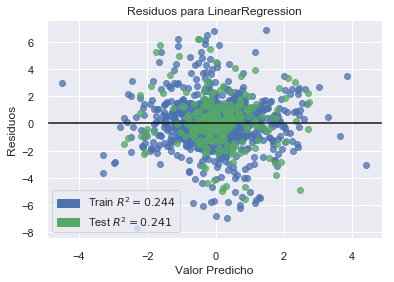

In [17]:
visualizer = ResidualsPlot(grid1.best_estimator_,title='Residuos para LinearRegression',hist=False)

visualizer.fit(X_train, y_train.values.ravel())  # Fit the training data to the model
visualizer.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

visualizer.finalize()
visualizer.ax.set_xlabel('Valor Predicho')
visualizer.ax.set_ylabel('Residuos')

#plt.savefig("LinearRegression_R2_train15.png",dpi=600,bbox_inches="tight")

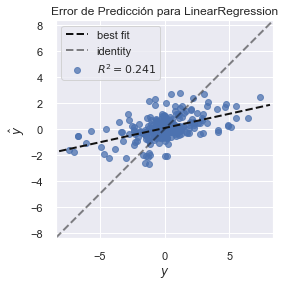

In [18]:
perror = PredictionError(grid1.best_estimator_, title='Error de Predicción para LinearRegression')

perror.fit(X_train, y_train.values.ravel())  # Fit the training data to the visualizer
perror.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

perror.finalize()
#plt.savefig("LinearRegression_PredictionError_train15.png",dpi=600,bbox_inches="tight")

#g = perror.poof()

In [19]:
full_data = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

Text(0, 0.5, 'Score')

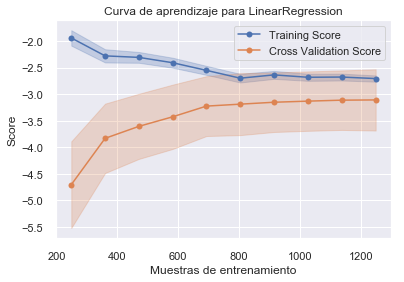

In [20]:

viz = LearningCurve(grid1.best_estimator_, cv=cv, n_jobs=-1,scoring='neg_mean_squared_error',
                    train_sizes=np.linspace(0.2, 1.0, 10),title='Curva de aprendizaje para LinearRegression')
viz.fit(full_data, y_full)

viz.finalize()

viz.ax.set_xlabel('Muestras de entrenamiento')
viz.ax.set_ylabel('Score')

#plt.savefig("LinearRegression_LearningCurve_train15.png",dpi=600,bbox_inches="tight")

#viz.poof()

In [64]:
print("RMSE CV Train {}".format(np.sqrt(-viz.train_scores_mean_[-1])))
print("RMSE CV Test {}".format(np.sqrt(-viz.test_scores_mean_[-1])))

RMSE CV Train 1.6238052725321324
RMSE CV Test 1.7541193114035778


# l2 regularization or Ridge, default


In [23]:
#1)  ORIGINAL
## Pipeline preprocessing
interactions = FeaturesInteractions(interaction1=X_train.columns[:15].tolist(),interaction2="van_der_waals_change")
skewness = SkewTransformer(threshold=0.6,method='quantile')
zeroth = ZeroThreshold(threshold=90.)

scaler = MinMaxScaler()
#2)
linear_model = Ridge()
#3) Crear pipeline
pipeline2 = make_pipeline(interactions,skewness,zeroth,scaler,linear_model)

# Use transformed target regressor
# regr_trans2 = TransformedTargetRegressor(regressor=pipeline2, 
#                                         transformer=QuantileTransformer(output_distribution='normal',random_state=13))


# grid params
# param_grid = {"regressor__ridge__alpha":[0.5,1.2,2],"regressor__ridge__normalize":[True,False],"regressor__ridge__fit_intercept":[True,False]}
#              #'regressor__variancethreshold__threshold':[0.001,0]}
param_grid = {"ridge__alpha":[0.1,0.2,0.3],"ridge__normalize":[True,False],"ridge__fit_intercept":[True,False]}
             #'regressor__variancethreshold__threshold':[0.001,0]}

cv = RepeatedKFold(n_splits=10,n_repeats=10,random_state=13)

# Instantiate the grid search model
grid2 = GridSearchCV(pipeline2, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='neg_mean_squared_error',return_train_score=True)

grid2.fit(X_train,y_train)

Fitting 100 folds for each of 12 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.0min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1a18c37dd8>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('featuresinteractions', FeaturesInteractions(interaction1=['clash', 'covalent', 'vdw_clash', 'vdw', 'proximal', 'hbond', 'weak_hbond', 'xbond', 'ionic', 'metal_complex', 'aromatic', 'hydrophobic', 'carbonyl', 'polar', 'weak_polar'],
           interaction2='van_der_waals_change')), ('skewtra...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'ridge__alpha': [0.1, 0.2, 0.3], 'ridge__normalize': [True, False], 'ridge__fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score=True, scoring=['neg_mean_squared_error', 'r2'],
       verbose=5)

In [24]:
# index of best scores
rmse_bestCV_test_index = grid2.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid2.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid2.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid2.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid2.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid2.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid2.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid2.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid2.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid2.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid2.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid2.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('DIFF RMSE {}'.format(np.sqrt(-rmse_bestCV_test_score)-np.sqrt(-rmse_bestCV_train_score)))

print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid2.best_params_)
y_test_pred = grid2.best_estimator_.predict(X_test)
y_train_pred = grid2.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test.values.ravel())[0][1]))
print('R2 test',r2_score(y_test,y_test_pred))
print('R2 train',r2_score(y_train,y_train_pred))

CV test RMSE 1.751574 +/- 0.830611
CV train RMSE 1.635891 +/- 0.266526
DIFF RMSE 0.11568350708412889
CV test r2 0.123902 +/- 0.082137
CV train r2 0.242933 +/- 0.009733
0.11903075264871053
 {'ridge__alpha': 0.2, 'ridge__fit_intercept': True, 'ridge__normalize': True}

RMSE for test dataset: 1.73
RMSE for train dataset: 1.68
pearson corr  0.521852
R2 test 0.24868278619115936
R2 train 0.20613944178751453


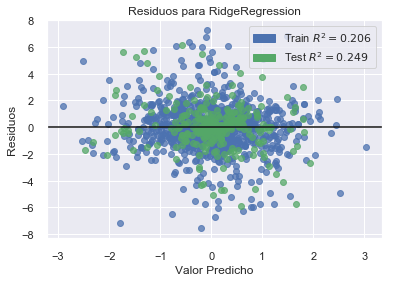

In [25]:
visualizer = ResidualsPlot(grid2.best_estimator_,title='Residuos para RidgeRegression',hist=False)

visualizer.fit(X_train, y_train.values.ravel())  # Fit the training data to the model
visualizer.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

visualizer.finalize()
visualizer.ax.set_xlabel('Valor Predicho')
visualizer.ax.set_ylabel('Residuos')

plt.savefig("RidgeRegression_R2_train15.png",dpi=600,bbox_inches="tight")

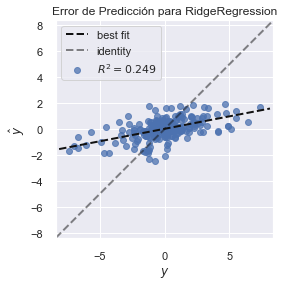

In [26]:
perror = PredictionError(grid2.best_estimator_, title='Error de Predicción para RidgeRegression')

perror.fit(X_train, y_train.values.ravel())  # Fit the training data to the visualizer
perror.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

perror.finalize()
plt.savefig("RidgeRegression_PredictionError_train15.png",dpi=600,bbox_inches="tight")

#g = perror.poof()


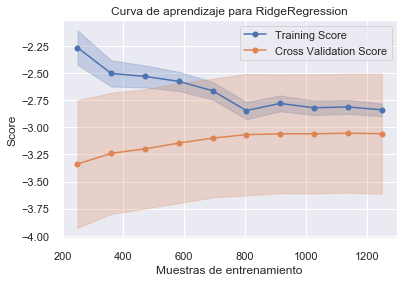

In [27]:
viz = LearningCurve(grid2.best_estimator_, cv=cv, n_jobs=-1,scoring='neg_mean_squared_error',
                    train_sizes=np.linspace(0.2, 1.0, 10),title='Curva de aprendizaje para RidgeRegression')
viz.fit(full_data, y_full)

viz.finalize()

viz.ax.set_xlabel('Muestras de entrenamiento')
viz.ax.set_ylabel('Score')

plt.savefig("RidgeRegression_LearningCurve_train15.png",dpi=600,bbox_inches="tight")

#viz.poof()

# LASSO

In [34]:
#1)  ORIGINAL

## Pipeline preprocessing
interactions = FeaturesInteractions(interaction1=X_train.columns[:15].tolist(),interaction2="van_der_waals_change")
skewness = SkewTransformer(threshold=0.6,method='quantile')
zeroth = ZeroThreshold(threshold=90.)

scaler = MinMaxScaler()


#2)
linear_model = Lasso()
#3) Crear pipeline
pipeline3 = make_pipeline(interactions,skewness,zeroth, scaler,linear_model)

# Use transformed target regressor
# regr_trans3 = TransformedTargetRegressor(regressor=pipeline3, 
#                                         transformer=QuantileTransformer(output_distribution='normal',random_state=13))


# grid params
# param_grid = {"regressor__lasso__alpha":[0.0004,0.0003,0.0002],"regressor__lasso__normalize":[True,False],
#               "regressor__lasso__fit_intercept":[False,True]}

param_grid = {"lasso__alpha":[0.0009,0.001],"lasso__normalize":[True,False],
              "lasso__fit_intercept":[True,False]}


cv = RepeatedKFold(n_splits=10,n_repeats=10,random_state=13)

# Instantiate the grid search model
grid3 = GridSearchCV(pipeline3, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='neg_mean_squared_error',return_train_score=True)

grid3.fit(X_train,y_train)

Fitting 100 folds for each of 8 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   50.2s finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1a1bdc86d8>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('featuresinteractions', FeaturesInteractions(interaction1=['clash', 'covalent', 'vdw_clash', 'vdw', 'proximal', 'hbond', 'weak_hbond', 'xbond', 'ionic', 'metal_complex', 'aromatic', 'hydrophobic', 'carbonyl', 'polar', 'weak_polar'],
           interaction2='van_der_waals_change')), ('skewtra...e=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'lasso__alpha': [0.0009, 0.001], 'lasso__normalize': [True, False], 'lasso__fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score=True, scoring=['neg_mean_squared_error', 'r2'],
       verbose=5)

In [36]:
# index of best scores
rmse_bestCV_test_index = grid3.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid3.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid3.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid3.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid3.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid3.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid3.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid3.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid3.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid3.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid3.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid3.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('DIFF RMSE {}'.format(np.sqrt(-rmse_bestCV_test_score)-np.sqrt(-rmse_bestCV_train_score)))

print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid3.best_params_)
y_test_pred = grid3.best_estimator_.predict(X_test)
y_train_pred = grid3.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test.values.ravel())[0][1]))
print('R2 test',r2_score(y_test,y_test_pred))
print('R2 train',r2_score(y_train,y_train_pred))

CV test RMSE 1.733526 +/- 0.821568
CV train RMSE 1.645964 +/- 0.265477
DIFF RMSE 0.08756166710518509
CV test r2 0.141491 +/- 0.082811
CV train r2 0.233573 +/- 0.009650
0.09208161286908725
 {'lasso__alpha': 0.0009, 'lasso__fit_intercept': True, 'lasso__normalize': True}

RMSE for test dataset: 1.72
RMSE for train dataset: 1.68
pearson corr  0.532328
R2 test 0.2562380078092381
R2 train 0.1982877528125757


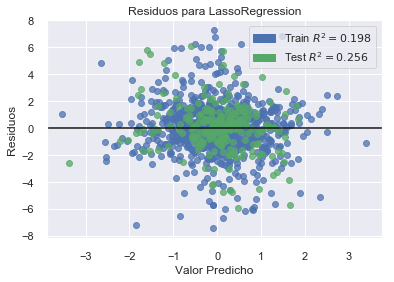

In [37]:
visualizer = ResidualsPlot(grid3.best_estimator_,title='Residuos para LassoRegression',hist=False)

visualizer.fit(X_train, y_train.values.ravel())  # Fit the training data to the model
visualizer.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

visualizer.finalize()
visualizer.ax.set_xlabel('Valor Predicho')
visualizer.ax.set_ylabel('Residuos')

plt.savefig("LassoRegression_R2_train15.png",dpi=600,bbox_inches="tight")

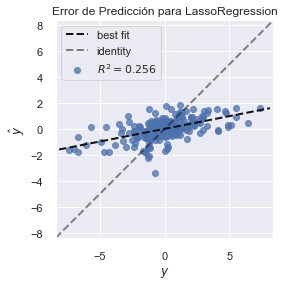

In [38]:
perror = PredictionError(grid3.best_estimator_, title='Error de Predicción para LassoRegression')

perror.fit(X_train, y_train.values.ravel())  # Fit the training data to the visualizer
perror.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

perror.finalize()
plt.savefig("LassoRegression_PredictionError_train15.png",dpi=600,bbox_inches="tight")

#g = perror.poof()

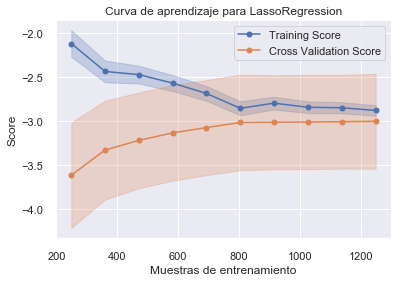

In [39]:
viz = LearningCurve(grid3.best_estimator_, cv=cv, n_jobs=-1,scoring='neg_mean_squared_error',
                    train_sizes=np.linspace(0.2, 1.0, 10),title='Curva de aprendizaje para LassoRegression')
viz.fit(full_data, y_full)

viz.finalize()

viz.ax.set_xlabel('Muestras de entrenamiento')
viz.ax.set_ylabel('Score')

plt.savefig("LassoRegression_LearningCurve_train15.png",dpi=600,bbox_inches="tight")

#viz.poof()

In [44]:
np.sqrt(viz.test_scores_std_)

array([0.77384438, 0.7504996 , 0.73726151, 0.73757601, 0.73517476,
       0.73712662, 0.73091127, 0.73229558, 0.73049073, 0.73433696])

# ElasticNet

In [47]:
#1)  ORIGINAL

## Pipeline preprocessing
interactions = FeaturesInteractions(interaction1=X_train.columns[:15].tolist(),interaction2="van_der_waals_change")
skewness = SkewTransformer(threshold=0.6,method='quantile')
zeroth = ZeroThreshold(threshold=90.)

scaler = MinMaxScaler()


#2)
linear_model = ElasticNet()
#3) Crear pipeline
pipeline4 = make_pipeline(interactions,skewness,zeroth, scaler,linear_model)

# Use transformed target regressor
# regr_trans4 = TransformedTargetRegressor(regressor=pipeline4, 
#                                         transformer=QuantileTransformer(output_distribution='normal',random_state=13))


# grid params
# param_grid = {"regressor__elasticnet__alpha":[0.0004,0.0003,0.0002],'regressor__elasticnet__l1_ratio':[1,0.9,1.1],
#               "regressor__elasticnet__normalize":[True],"regressor__elasticnet__fit_intercept":[True]}

param_grid = {"elasticnet__alpha":[0.001,0.0009],'elasticnet__l1_ratio':[1,1.1,0.9],
              "elasticnet__normalize":[True,False],"elasticnet__fit_intercept":[True,False]}
cv = RepeatedKFold(n_splits=10,n_repeats=10,random_state=13)

# Instantiate the grid search model
grid4 = GridSearchCV(pipeline4, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='neg_mean_squared_error',return_train_score=True)

grid4.fit(X_train,y_train)

Fitting 100 folds for each of 24 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  2.4min finished
/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1a19466240>,
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('featuresinteractions', FeaturesInteractions(interaction1=['clash', 'covalent', 'vdw_clash', 'vdw', 'proximal', 'hbond', 'weak_hbond', 'xbond', 'ionic', 'metal_complex', 'aromatic', 'hydrophobic', 'carbonyl', 'polar', 'weak_polar'],
           interaction2='van_der_waals_change')), ('skewtra...alse, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'elasticnet__alpha': [0.001, 0.0009], 'elasticnet__l1_ratio': [1, 1.1, 0.9], 'elasticnet__normalize': [True, False], 'elasticnet__fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score=True, scoring=['neg_mean_squared_error', 'r2'],
       verbose=5)

In [48]:
# index of best scores
rmse_bestCV_test_index = grid4.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid4.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid4.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid4.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid4.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid4.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid4.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid4.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid4.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid4.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid4.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid4.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('DIFF RMSE {}'.format(np.sqrt(-rmse_bestCV_test_score)-np.sqrt(-rmse_bestCV_train_score)))

print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid4.best_params_)
y_test_pred = grid4.best_estimator_.predict(X_test)
y_train_pred = grid4.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test.values.ravel())[0][1]))
print('R2 test',r2_score(y_test,y_test_pred))
print('R2 train',r2_score(y_train,y_train_pred))

CV test RMSE 1.733526 +/- 0.821568
CV train RMSE 1.645964 +/- 0.265477
DIFF RMSE 0.08756166710518509
CV test r2 0.141491 +/- 0.082811
CV train r2 0.233573 +/- 0.009650
0.09208161286908725
 {'elasticnet__alpha': 0.0009, 'elasticnet__fit_intercept': True, 'elasticnet__l1_ratio': 1, 'elasticnet__normalize': True}

RMSE for test dataset: 1.72
RMSE for train dataset: 1.68
pearson corr  0.532328
R2 test 0.2562380078092381
R2 train 0.1982877528125757


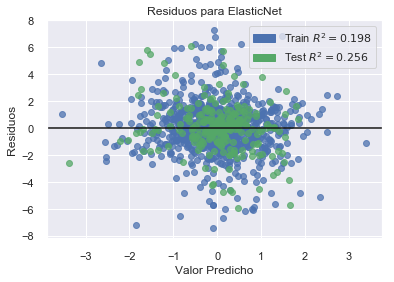

In [49]:
visualizer = ResidualsPlot(grid4.best_estimator_,title='Residuos para ElasticNet',hist=False)

visualizer.fit(X_train, y_train.values.ravel())  # Fit the training data to the model
visualizer.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

visualizer.finalize()
visualizer.ax.set_xlabel('Valor Predicho')
visualizer.ax.set_ylabel('Residuos')

plt.savefig("ElasticNet_R2_train15.png",dpi=600,bbox_inches="tight")

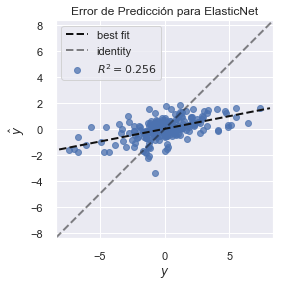

In [50]:
perror = PredictionError(grid4.best_estimator_, title='Error de Predicción para ElasticNet')

perror.fit(X_train, y_train.values.ravel())  # Fit the training data to the visualizer
perror.score(X_test, y_test.values.ravel())  # Evaluate the model on the test data

perror.finalize()
plt.savefig("ElasticNet_PredictionError_train15.png",dpi=600,bbox_inches="tight")

#g = perror.poof()

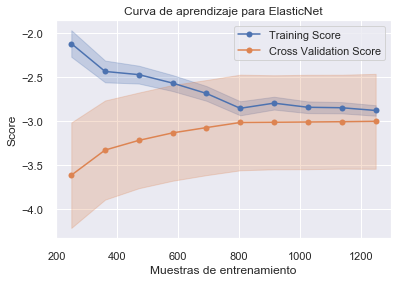

In [51]:
viz = LearningCurve(grid4.best_estimator_, cv=cv, n_jobs=-1,scoring='neg_mean_squared_error',
                    train_sizes=np.linspace(0.2, 1.0, 10),title='Curva de aprendizaje para ElasticNet')
viz.fit(full_data, y_full)

viz.finalize()

viz.ax.set_xlabel('Muestras de entrenamiento')
viz.ax.set_ylabel('Score')

plt.savefig("ElasticNet_LearningCurve_train15.png",dpi=600,bbox_inches="tight")

#viz.poof()

In [52]:
np.sqrt(viz.test_scores_std_)

array([0.77384438, 0.7504996 , 0.73726151, 0.73757601, 0.73517476,
       0.73712662, 0.73091127, 0.73229558, 0.73049073, 0.73433696])

In [140]:
# Save best lienar model

In [53]:
final_linear = grid3.best_estimator_.fit(full_data,y_full)
# save final model

joblib.dump(final_linear, 'Lasso_train15skempiAB_FINAL.pkl')

['Lasso_train15skempiAB_FINAL.pkl']